In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

## Data Acquisition - Select Cryptocurrencies of Interest
1. Get all coin data from http://coincap.io/front
2. Select coins with Market cap more than selected threshold

In [2]:
all_coins_dict = json.loads(BeautifulSoup(
        requests.get('http://coincap.io/front').content, "html.parser").prettify())
all_coins_df = pd.DataFrame(all_coins_dict)
coins_by_mcap = all_coins_df[all_coins_df.mktcap > 5e9]
coin_portfolio = coins_by_mcap['short']
print("Portfolio coins with MCAP > 5 Billion :\n",coin_portfolio.values)

Portfolio coins with MCAP > 5 Billion :
 ['BTC' 'ETH' 'XRP' 'BCH' 'ADA' 'LTC' 'XEM' 'NEO' 'XLM' 'EOS' 'IOT' 'DASH'
 'XMR' 'TRX']


## Acquire Data - Get Historical Prices
1. Get all the price data for a particular coin from http://coincap.io/history/180day/<coin>
2. Create a master dataframe to hold historical price data for all the selected coins

In [3]:
#Create a DataFrame that will hold all the price & data for all the selected coins
combined_df = pd.DataFrame()

#Loop thru all the coins in the portfolio & get their historical prices. (180 days)
for coin in coin_portfolio:
    dic_t = json.loads(BeautifulSoup(
            requests.get('http://coincap.io/history/180day/'+coin).
            content, "html.parser").prettify())
    prices = dic_t.get('price')
    coindf = pd.DataFrame.from_records(prices,columns=['time','price'])
    coindf['coin'] = coin
    combined_df = combined_df.append(coindf, ignore_index=True)

## Data Wrangling 

Clean the historical price data, and find the returns and covariance

In [4]:
#Change the time formart
combined_df['time'] = pd.to_datetime(combined_df['time'],unit='ms')
combined_df['time'] = [d.date() for d in combined_df['time']]

operational_df = combined_df.groupby(['time', 'coin'],as_index=False)[['price']].mean()
operational_df = operational_df.set_index('time')

pivoted_portfolio = operational_df.pivot(columns='coin')

# get covariance & returns of the coin - daily & for the period 

daily_returns = pivoted_portfolio.pct_change()
period_returns = daily_returns.mean()*180

daily_covariance = daily_returns.cov()
period_covariance = daily_covariance*180

## Optimize portfolio

In [5]:
p_returns, p_volatility, p_sharpe_ratio, p_coin_weights=([] for i in range(4))

# portfolio combinations to probe
number_of_cryptoassets = len(coin_portfolio)
number_crypto_portfolios = 50000

# for each portoflio, get returns, risk and weights
for a_crypto_portfolio in range(number_crypto_portfolios):
    weights = np.random.random(number_of_cryptoassets)
    weights /= np.sum(weights)
    
    #print(weights)
    returns = np.dot(weights, period_returns)*100
    
    #print(weights)
    volatility = np.sqrt(np.dot(weights.T, np.dot(period_covariance, weights)))*100
   
    p_sharpe_ratio.append(returns/volatility)
    p_returns.append(returns)
    p_volatility.append(volatility)
    p_coin_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'volatility': p_volatility,
             'sharpe_ratio': p_sharpe_ratio, 'returns': p_returns}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(coin_portfolio):
    portfolio[symbol+'-%'] = [Weight[counter] for Weight in p_coin_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

## Visualize - Efficient Frontier

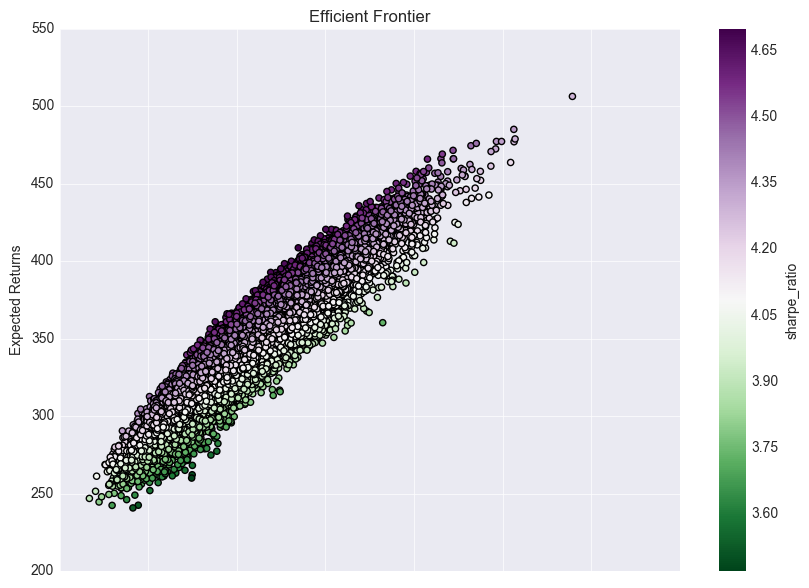

In [6]:
order_cols = ['returns', 'volatility', 'sharpe_ratio']+[coin+'-%' for coin in coin_portfolio]
df = df[order_cols]

sharpe_portfolio = df.loc[df['sharpe_ratio'] == df['sharpe_ratio'].max()]
min_variance_port = df.loc[df['volatility'] == df['volatility'].min()]
max_returns_port = df.loc[df['returns'] == df['returns'].max()]

plt.style.use('seaborn-dark')
df.plot.scatter(x='volatility', y='returns', c='sharpe_ratio', cmap='PRGn_r', 
                edgecolors='black', figsize=(10, 7), grid=True)

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [7]:
print('****Portfolio llocations*****')
print(sharpe_portfolio.T)

****Portfolio llocations*****
                   30485
returns       408.505284
volatility     86.933811
sharpe_ratio    4.699038
BTC-%           0.149927
ETH-%           0.087094
XRP-%           0.141943
BCH-%           0.019183
ADA-%           0.015808
LTC-%           0.035945
XEM-%           0.053047
NEO-%           0.014573
XLM-%           0.115310
EOS-%           0.100890
IOT-%           0.031353
DASH-%          0.070901
XMR-%           0.127235
TRX-%           0.036790
